## [scikit-learn](https://scikit-learn.org/stable/) has the most extensive machine learning algorithms and good documentation

## UMAP is implemented in a dedicated [umap-learn](https://umap-learn.readthedocs.io/en/latest/) package

### Visit these pages to get deeper understanding of [t-SNE](https://distill.pub/2016/misread-tsne/) and [UMAP](https://pair-code.github.io/understanding-umap/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

from scipy.spatial.distance import pdist, squareform

## Today's data is from [3,200 colorectal cancer patients](https://pubmed.ncbi.nlm.nih.gov/26457759/)
62 genes were selected from 6,000 to simplify the dataset

Mutation of key genes and microsatellite instability also included in the last columns

In [2]:
data = pd.read_excel('CRC_62gene_full.xlsx', index_col = 0, header = 0)
data.head(3)

,FAP,SLC5A6,GFPT2,ASCL2,TSPAN6,CCDC80,DUSP4,EFEMP2,TRIM7,DCN,...,TCN1,MCUB,PLEKHO1,CLDN11,CAB39L,KRAS,BRAF,APC,TP53,microsatelite_status
Patient ID,,,,,,,,,,,,,,,,,,,,,
Patient1,6.426144,7.480255,5.171818,7.644062,8.563220,5.741716,5.127825,6.736410,6.663504,8.300320,...,4.127128,7.277680,6.971997,3.131409,5.654089,NaN,NaN,NaN,NaN,NaN
Patient2,6.744163,7.098519,5.022608,6.151806,6.893496,6.607037,5.686189,6.835865,5.171759,8.900216,...,8.280611,6.492556,6.432994,3.326791,4.499255,NaN,NaN,NaN,NaN,NaN
Patient3,5.372873,6.853864,4.437102,4.169346,7.180989,5.619574,8.339366,6.014007,6.834014,6.705742,...,8.135574,7.510114,6.642960,4.395318,4.418997,NaN,NaN,NaN,NaN,NaN


## Extract gene expression part

In [3]:
first_mutation_column = list(data.columns).index('KRAS')

exp_data = data.iloc[:, :first_mutation_column]
exp_data.head(3)

,FAP,SLC5A6,GFPT2,ASCL2,TSPAN6,CCDC80,DUSP4,EFEMP2,TRIM7,DCN,...,SERPINB1,SEMA5A,ANO7,VAV3,RAB27B,TCN1,MCUB,PLEKHO1,CLDN11,CAB39L
Patient ID,,,,,,,,,,,,,,,,,,,,,
Patient1,6.426144,7.480255,5.171818,7.644062,8.563220,5.741716,5.127825,6.736410,6.663504,8.300320,...,7.277585,6.426278,4.340957,5.861012,4.439092,4.127128,7.277680,6.971997,3.131409,5.654089
Patient2,6.744163,7.098519,5.022608,6.151806,6.893496,6.607037,5.686189,6.835865,5.171759,8.900216,...,7.800155,5.911080,5.196913,5.395907,3.753465,8.280611,6.492556,6.432994,3.326791,4.499255
Patient3,5.372873,6.853864,4.437102,4.169346,7.180989,5.619574,8.339366,6.014007,6.834014,6.705742,...,8.555077,4.568031,6.099642,5.679259,4.371925,8.135574,7.510114,6.642960,4.395318,4.418997


# Dimensionality reduction
## Let's start with PCA
For PCA, data must be centered (each column has zero mean)

But it's optional whether to scale the data (each column has unit variance)

### First, PCA with centered data

In [5]:
centered_data = exp_data - exp_data.mean()

print(centered_data.mean())

FAP       -2.989908e-16
SLC5A6    -4.352954e-16
GFPT2      1.231138e-16
ASCL2      6.947138e-16
TSPAN6     3.891277e-16
               ...     
TCN1      -4.396923e-17
MCUB       2.945938e-16
PLEKHO1    3.693415e-16
CLDN11     2.462277e-16
CAB39L    -7.474769e-17
Length: 62, dtype: float64


In [6]:
centered_pca = PCA(random_state = 25).fit(centered_data)
centered_pca_embed = centered_pca.transform(centered_data)

### View amount of explained variance in each component

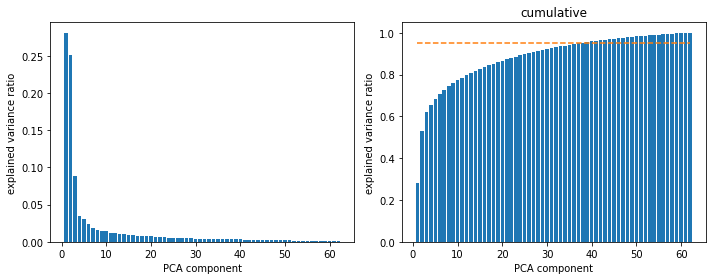

In [15]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, centered_pca.n_components_ + 1), centered_pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('explained variance ratio')

plt.subplot(1, 2, 2)
cumulative = np.cumsum(centered_pca.explained_variance_ratio_)
plt.bar(range(1, centered_pca.n_components_ + 1), cumulative)
plt.plot([1, exp_data.shape[1]], [0.95, 0.95], '--', color = 'tab:orange')
plt.xlabel('PCA component')
plt.ylabel('explained variance ratio')
plt.title('cumulative')

plt.tight_layout()
plt.show()

### Observation
* The first two components capture >25% of variance each
* About 38 components can capture 90% of the total variance

### View PCA embedding of the first two components
Color by some genes

In [9]:
np.random.seed(25)
random_genes = np.random.choice(exp_data.columns, 4, replace = False)

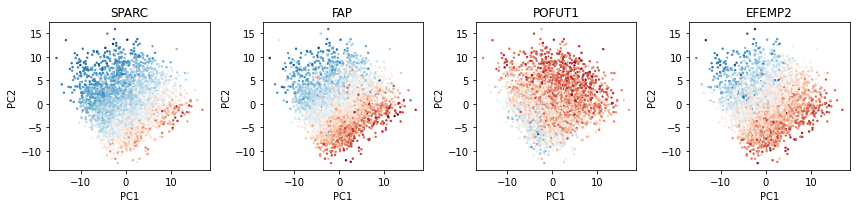

In [78]:
plt.figure(figsize = (12, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(centered_pca_embed[:, 0], centered_pca_embed[:, 1], c = exp_data[random_genes[i]], cmap = 'RdBu', s = 2)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(random_genes[i])

plt.tight_layout()
plt.show()

### View loadings on the first two components

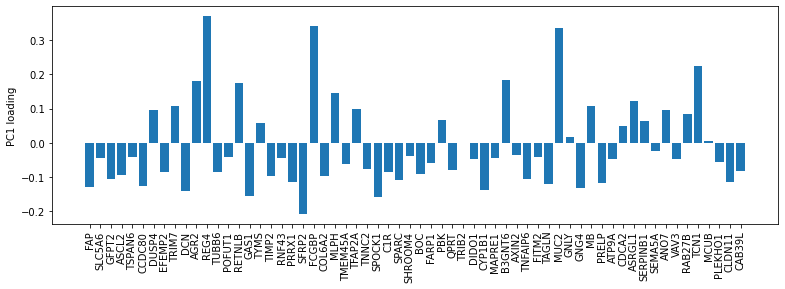

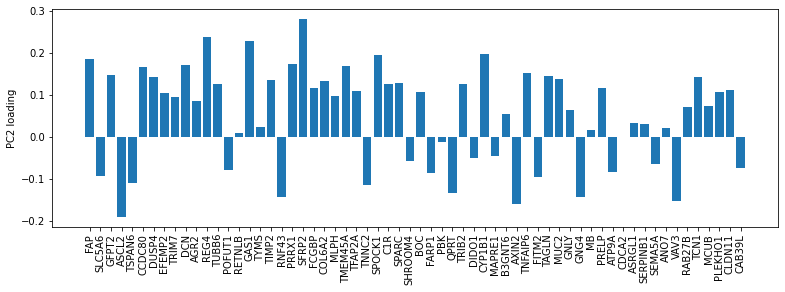

In [21]:
plt.figure(figsize = (13, 4))
plt.bar(range(exp_data.shape[1]), centered_pca.components_[0])
plt.xticks(range(exp_data.shape[1]), labels = exp_data.columns, rotation = 90)
plt.ylabel('PC1 loading')
plt.show()

plt.figure(figsize = (13, 4))
plt.bar(range(exp_data.shape[1]), centered_pca.components_[1])
plt.xticks(range(exp_data.shape[1]), labels = exp_data.columns, rotation = 90)
plt.ylabel('PC2 loading')
plt.show()

### Observation
* PC1 focuses on REG4, FCGBP, and MUC2
* PC2 has a lot of similar loadings, with the top three being SFRP2, REG4 (again), and GAS1

### Let's check the expression variance of these genes

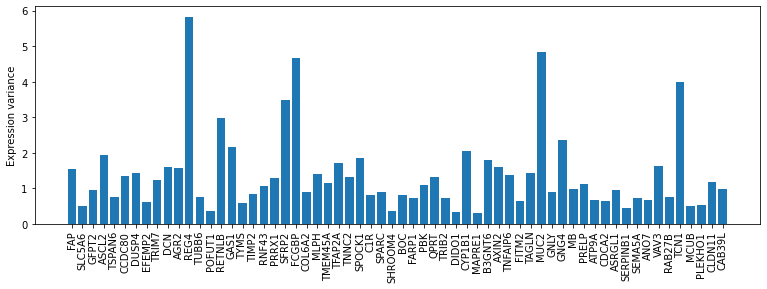

In [24]:
plt.figure(figsize = (13, 4))
plt.bar(range(exp_data.shape[1]), centered_data.var())
plt.xticks(range(exp_data.shape[1]), labels = exp_data.columns, rotation = 90)
plt.ylabel('Expression variance')
plt.show()

### Observation
* REG4, FCGBP, and MUC2 have the highest expression variances --> hence, PC1 focus on them

### Let's re-run PCA with standardized data instead

In [4]:
std_data = (exp_data - exp_data.mean()) / exp_data.std()
print(std_data.std())

FAP        1.0
SLC5A6     1.0
GFPT2      1.0
ASCL2      1.0
TSPAN6     1.0
          ... 
TCN1       1.0
MCUB       1.0
PLEKHO1    1.0
CLDN11     1.0
CAB39L     1.0
Length: 62, dtype: float64


In [5]:
std_pca = PCA(random_state = 25).fit(std_data)
std_pca_embed = std_pca.transform(std_data)

### Compare new loadings with previous one

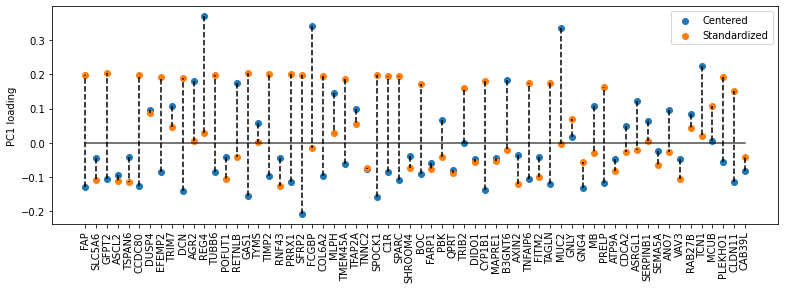

In [50]:
plt.figure(figsize = (13, 4))
plt.scatter(range(exp_data.shape[1]), centered_pca.components_[0], label = 'Centered')
plt.scatter(range(exp_data.shape[1]), std_pca.components_[0], label = 'Standardized')
plt.xticks(range(exp_data.shape[1]), labels = exp_data.columns, rotation = 90)
plt.ylabel('PC1 loading'); plt.legend()

plt.plot([0, exp_data.shape[1] - 1], [0, 0], 'k', alpha = 0.7)

### Add arrow
for i in range(exp_data.shape[1]):
    plt.plot([i, i], [centered_pca.components_[0][i], std_pca.components_[0][i]], 'k--')

plt.show()

### Observation
With standardization, PC1 now assigns similar weights to many genes instead of to ony 3-4 genes

### Check the new explained variance and embedding

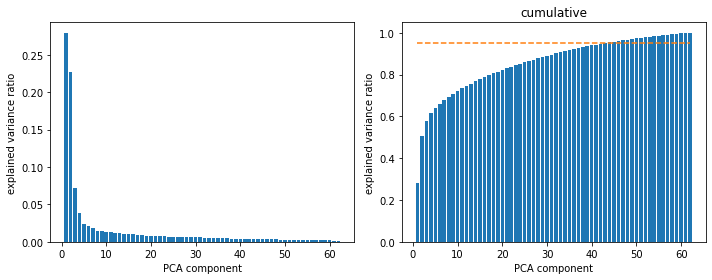

In [51]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, std_pca.n_components_ + 1), std_pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('explained variance ratio')

plt.subplot(1, 2, 2)
cumulative = np.cumsum(std_pca.explained_variance_ratio_)
plt.bar(range(1, std_pca.n_components_ + 1), cumulative)
plt.plot([1, exp_data.shape[1]], [0.95, 0.95], '--', color = 'tab:orange')
plt.xlabel('PCA component')
plt.ylabel('explained variance ratio')
plt.title('cumulative')

plt.tight_layout()
plt.show()

Centered data


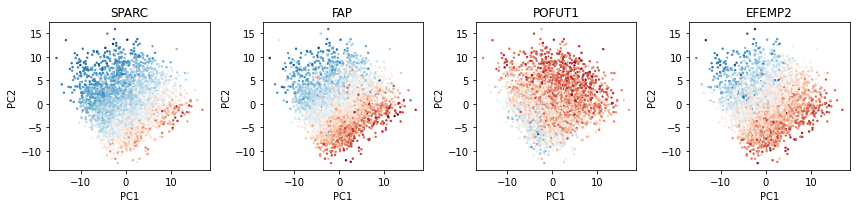

---------------------------------------------------------------
Standardized data


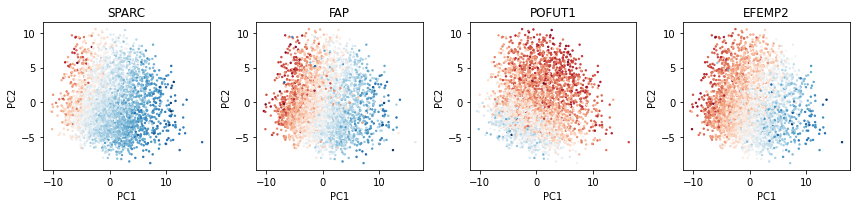

In [77]:
print('Centered data')
plt.figure(figsize = (12, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(centered_pca_embed[:, 0], centered_pca_embed[:, 1], c = exp_data[random_genes[i]], cmap = 'RdBu', s = 2)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(random_genes[i])

plt.tight_layout()
plt.show()

print('---------------------------------------------------------------')
print('Standardized data')
plt.figure(figsize = (12, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(std_pca_embed[:, 0], std_pca_embed[:, 1], c = exp_data[random_genes[i]], cmap = 'RdBu', s = 2)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(random_genes[i])

plt.tight_layout()
plt.show()

### Observation
* The embedding and explained variances are similar between the two method
* But the interpretation of genes are completely different

## To use non-Euclidean distance, we need to switch from PCA to MDS
MDS function in scikit-learn requires the non-Euclidean distance matrix be *precomputed*

**Important**: Correlation is a similarity function (higher = more similar), not a distance function (higher = less similar). Use **1 - correlation** instead.

In [6]:
corr_matrix = std_data.T.corr(method = 'pearson')
display(corr_matrix.head(3))

Patient ID,Patient1,Patient2,Patient3,Patient4,Patient5,Patient6,Patient7,Patient8,Patient9,Patient10,...,Patient3223,Patient3224,Patient3225,Patient3226,Patient3227,Patient3228,Patient3229,Patient3230,Patient3231,Patient3232
Patient ID,,,,,,,,,,,,,,,,,,,,,
Patient1,1.000000,0.268248,0.313797,0.554337,0.313399,0.513234,0.338535,0.493208,0.574029,0.125381,...,-0.309922,-0.005933,-0.237748,-0.227737,0.157790,-0.071780,-0.386341,-0.312668,0.102221,-0.434195
Patient2,0.268248,1.000000,0.583847,0.434452,0.307415,0.349787,0.433501,0.151007,0.318250,0.529984,...,-0.464379,-0.260968,-0.559948,-0.293037,0.172662,-0.219973,-0.257983,-0.502772,-0.099950,-0.242364
Patient3,0.313797,0.583847,1.000000,0.425252,0.576141,0.508907,0.477143,0.389104,0.605971,0.619210,...,-0.725875,-0.151191,-0.734827,-0.407866,0.084966,-0.534500,-0.458682,-0.689711,0.151827,-0.337188


In [7]:
corr_mds = MDS(n_components = 2, random_state = 25, dissimilarity = 'precomputed')
corr_mds_embed = corr_mds.fit_transform(1 - corr_matrix)

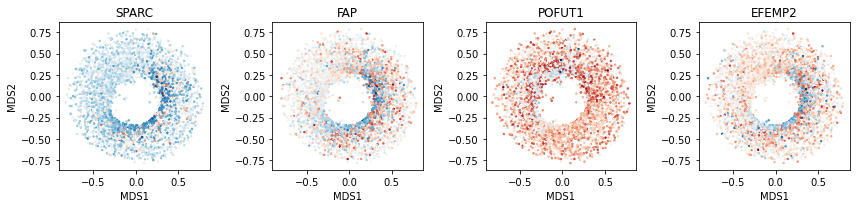

In [10]:
plt.figure(figsize = (12, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(corr_mds_embed[:, 0], corr_mds_embed[:, 1], c = exp_data[random_genes[i]], cmap = 'RdBu', s = 2)
    plt.xlabel('MDS1'); plt.ylabel('MDS2')
    plt.title(random_genes[i])

plt.tight_layout()
plt.show()

### Observation
* MDS with correlation generate a different pattern than PCA
* MDS took *quite a while* to fit the data

## t-SNE
We can use either standardized data + Euclidean or raw data + correlation

Try several perplexity values

Use **%%timeit** to measure the amount of CPU time used

c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in

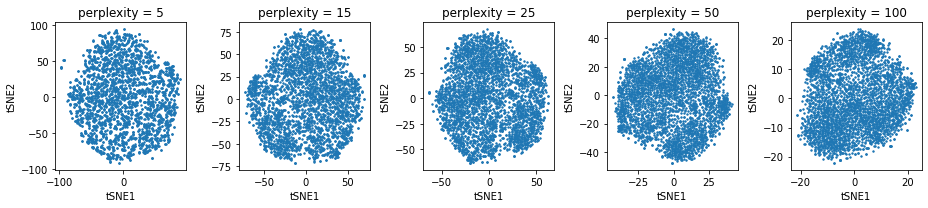

1min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
%%timeit -r 1 -n 1
perplexities = [5, 15, 25, 50, 100]

plt.figure(figsize = (13, 3))

for i, k in enumerate(perplexities, start = 1):
    plt.subplot(1, 5, i)
    tsne_embed = TSNE(n_components = 2, perplexity = k, random_state = 25).fit_transform(std_data)
    plt.scatter(tsne_embed[:, 0], tsne_embed[:, 1], s = 2)
    plt.xlabel('tSNE1'); plt.ylabel('tSNE2')
    plt.title('perplexity = ' + str(k))

plt.tight_layout()
plt.show()

## UMAP
Similar to t-SNE. Try several neighbor values

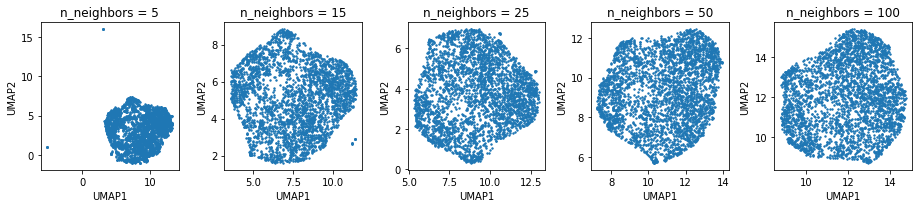

1min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [70]:
%%timeit -r 1 -n 1 ## measure the amount of CPU time used
neighbers = [5, 15, 25, 50, 100]

plt.figure(figsize = (13, 3))

for i, n in enumerate(neighbers, start = 1):
    plt.subplot(1, 5, i)
    umap_embed = umap.UMAP(n_components = 2, n_neighbors = n, random_state = 25).fit_transform(std_data)
    plt.scatter(umap_embed[:, 0], umap_embed[:, 1], s = 2)
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    plt.title('n_neighbors = ' + str(n))

plt.tight_layout()
plt.show()

### Recalculate UMAP with n_neighbors = 25

In [72]:
umap_embed = umap.UMAP(n_components = 2, n_neighbors = 25, random_state = 25).fit_transform(std_data)

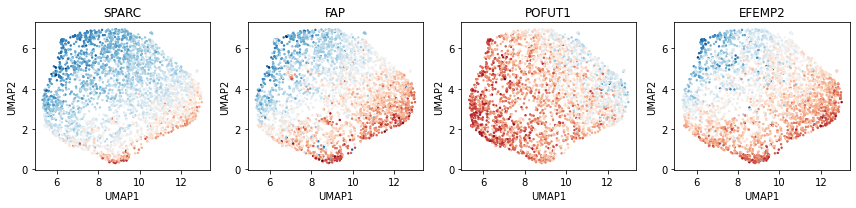

In [81]:
plt.figure(figsize = (12, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c = exp_data[random_genes[i]], cmap = 'RdBu', s = 2)
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    plt.title(random_genes[i])

plt.tight_layout()
plt.show()

### Observation
* Consistent structure when perplexity / n_neighbors are 15 or higher
* Similar gradient of gene expressions as PCA

## UMAP with Pearson's correlation

In [12]:
corr_umap_embed = umap.UMAP(n_components = 2, n_neighbors = 25, random_state = 25, metric = 'correlation').fit_transform(std_data)

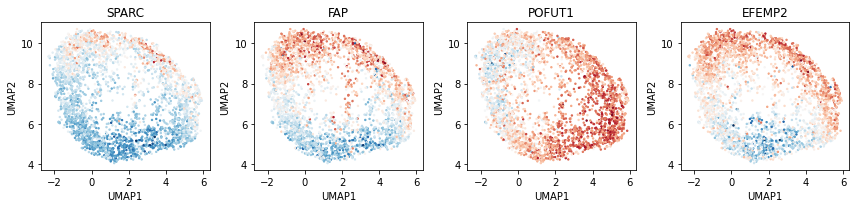

In [11]:
plt.figure(figsize = (12, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(corr_umap_embed[:, 0], corr_umap_embed[:, 1], c = exp_data[random_genes[i]], cmap = 'RdBu', s = 2)
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    plt.title(random_genes[i])

plt.tight_layout()
plt.show()

### Observation
* UMAP with correlation reveals more details on the ring structure than MDS

### Effect of min_dist

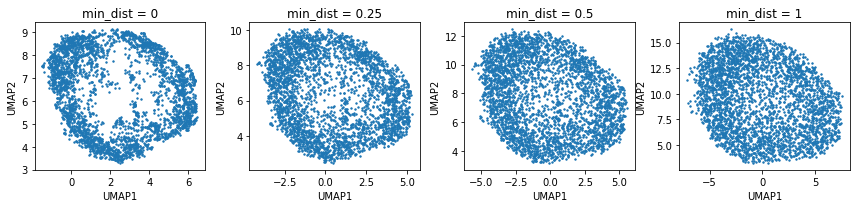

In [209]:
min_dists = [0, 0.25, 0.5, 1]

plt.figure(figsize = (12, 3))

for i, m in enumerate(min_dists, start = 1):
    plt.subplot(1, 4, i)
    umap_embed = umap.UMAP(n_components = 2, n_neighbors = 25, min_dist = m, random_state = 25, 
                           metric = 'correlation').fit_transform(std_data)
    plt.scatter(umap_embed[:, 0], umap_embed[:, 1], s = 2)
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    plt.title('min_dist = ' + str(m))

plt.tight_layout()
plt.show()

### Finalize UMAP embedding to be used later on

In [18]:
final_umap_embed = umap.UMAP(n_components = 2, n_neighbors = 25, min_dist = 0, 
                             random_state = 25, metric = 'correlation').fit_transform(std_data)

# Clustering with [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)

## Various [clustering scoring functions](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics)

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

## k-mean

In [108]:
kmean_silhouette = []
kmean_caha = []

for k in range(2, 10):
    kmean = KMeans(n_clusters = k, random_state = 25).fit_predict(std_data)
    kmean_silhouette.append(silhouette_score(std_data, kmean))
    kmean_caha.append(calinski_harabasz_score(std_data, kmean))

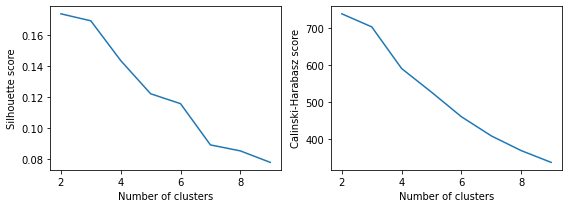

In [112]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), kmean_silhouette)
plt.xlabel('Number of clusters'); plt.ylabel('Silhouette score')

plt.subplot(1, 2, 2)
plt.plot(range(2, 10), kmean_caha)
plt.xlabel('Number of clusters'); plt.ylabel('Calinski-Harabasz score')

plt.tight_layout()
plt.show()

### Visualize the location of the two clusters

In [16]:
def view_clusters(labels):
    plt.figure(figsize = (10, 5))

    plt.subplot(1, 2, 1)

    for k in np.unique(labels):
        filt = labels == k
        plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], s = 2, label = 'Cluster ' + str(k))

    plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.legend()

    plt.subplot(1, 2, 2)

    for k in np.unique(labels):
        filt = labels == k
        plt.scatter(std_pca_embed[filt, 0], std_pca_embed[filt, 1], s = 2, label = 'Cluster ' + str(k))

    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()

    plt.tight_layout()
    plt.show()

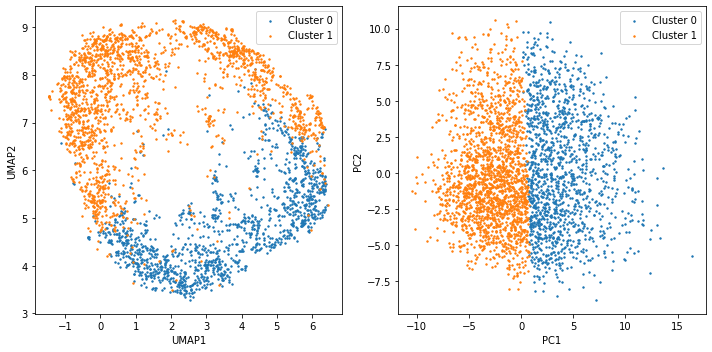

In [211]:
predicted = KMeans(n_clusters = 2, random_state = 25).fit_predict(std_data)
view_clusters(predicted)

### k-mean is not compatible with non-Euclidean distance
## Agglomerative / Hierarchical clustering 

In [13]:
def evaluate_clustering(n_clusters, method, data = std_data):
    silhouette = []
    caha = []

    for k in n_clusters:
        method.n_clusters = k
        predicted = method.fit_predict(data)
        silhouette.append(silhouette_score(data, predicted))
        caha.append(calinski_harabasz_score(data, predicted))
        
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 10), silhouette)
    plt.xlabel('Number of clusters'); plt.ylabel('Silhouette score')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, 10), caha)
    plt.xlabel('Number of clusters'); plt.ylabel('Calinski-Harabasz score')

    plt.tight_layout()
    plt.show()

### Try with Euclidean distance

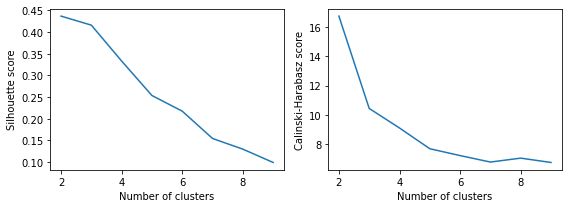

In [120]:
evaluate_clustering(range(2, 10), AgglomerativeClustering(affinity = 'euclidean', linkage = 'average'))

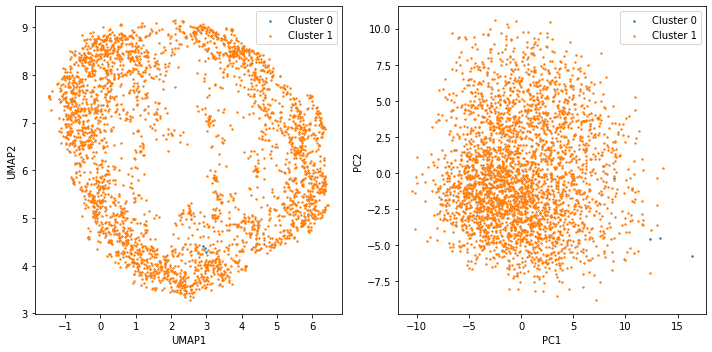

In [212]:
predicted = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'average').fit_predict(std_data)
view_clusters(predicted)

### Visualize hierarchical clustering with seaborn's [clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html)

c:\python38\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


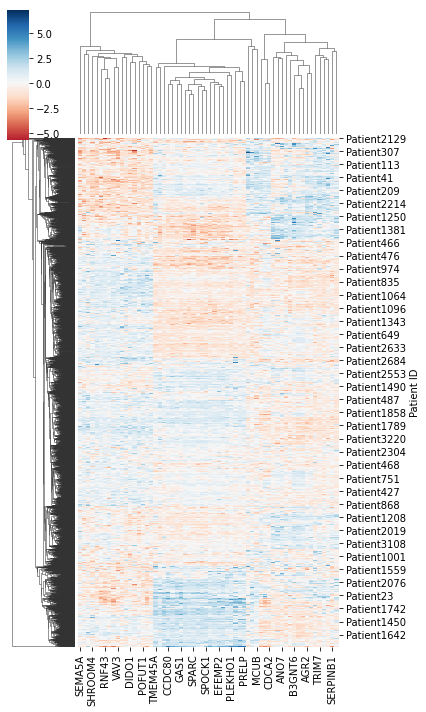

In [213]:
_ = sns.clustermap(data = std_data, metric = 'euclidean', method = 'average', 
                   z_score = None, figsize = (6, 10), cmap = 'RdBu', center = 0, 
                   row_cluster = True, col_cluster = True, 
                   row_colors = None, col_colors = None)

### Observation
* There is a group of outliers in the dendrogram
* Hierarchical clustering with n_clusters = 2 simply distinguish these outliers from other patients

### With correlation distance

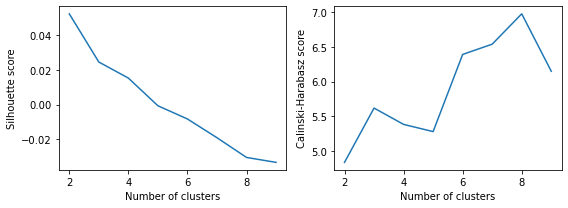

In [14]:
evaluate_clustering(range(2, 10), AgglomerativeClustering(affinity = 'precomputed', linkage = 'average'), data = 1 - corr_matrix)

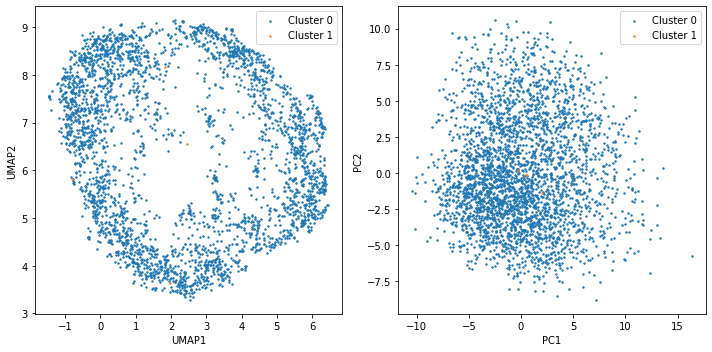

In [19]:
predicted = AgglomerativeClustering(n_clusters = 2, affinity = 'precomputed', linkage = 'average').fit_predict(1 - corr_matrix)
view_clusters(predicted)

### Check with clustermap

c:\python38\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


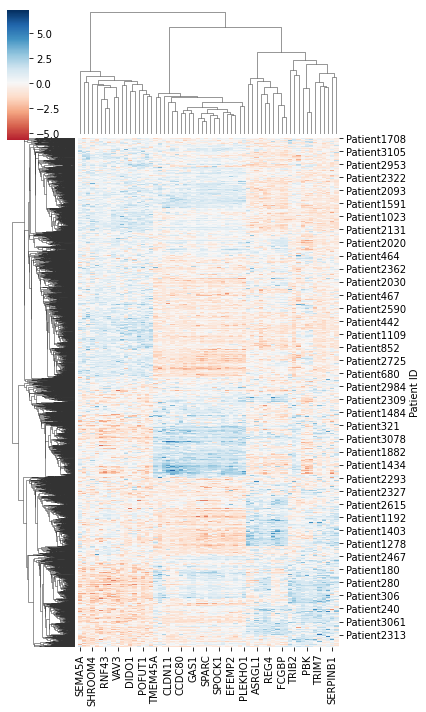

In [216]:
_ = sns.clustermap(data = std_data, metric = 'correlation', method = 'average', 
                   z_score = None, figsize = (6, 10), cmap = 'RdBu', center = 0, 
                   row_cluster = True, col_cluster = True, 
                   row_colors = None, col_colors = None)

## DBSCAN doesn't need the number of cluster to be specified
But we need to tune **epsilon** instead

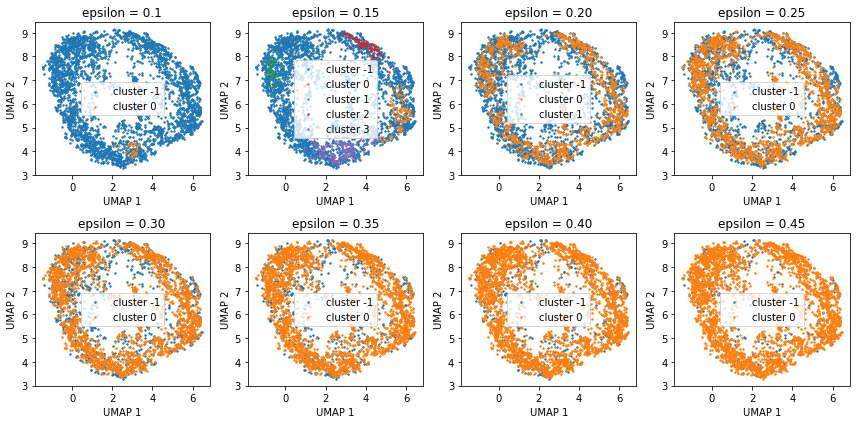

In [21]:
start = 0.1
step = 0.05
eps = np.arange(start, step * 8 + start, step)

plt.figure(figsize = (12, 6))

for i, e in enumerate(eps, start = 1):
    plt.subplot(2, 4, i)
    dbscan = DBSCAN(eps = e, metric = 'correlation', min_samples = 10)
    predicted = dbscan.fit_predict(std_data)
    
    for k in sorted(np.unique(predicted)):
        filt = predicted == k
        plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], label = 'cluster ' + str(k), s = 2)

    plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.legend()
    plt.title('epsilon = ' + str(e)[:4])

plt.tight_layout()
plt.show()    

### Observation
* DBSCAN is a density-based technique
* Since the key structure here is continuous, DBSCAN detect only a single dense cluster

## Lastly, network clustering
[Louvain and Leiden](https://www.nature.com/articles/s41598-019-41695-z) algorithms

In [8]:
# !pip install --upgrade python-louvain networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.7 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.6
    Uninstalling networkx-2.8.6:
      Successfully uninstalled networkx-2.8.6
  DEPRECATION: python-louvain is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for python-louvain ... done


In [9]:
import networkx as nx
import community

## Create a network of absolute correlation between patients
### Remove edges with correlation less than 0.7 to simplify the data
Don't worry about the details. [Networkx](https://networkx.org/) commands are beyond the scope of this course

In [13]:
thresholded_corr_matrix = exp_data.T.corr(method = 'pearson').to_numpy()
thresholded_corr_matrix[thresholded_corr_matrix < 0.7] = 0
thresholded_corr_matrix -= np.eye(data.shape[0]) ## remove diagonal entries
    
correlation_network = nx.from_numpy_array(thresholded_corr_matrix)
correlation_network = nx.relabel_nodes(correlation_network, lambda x: data.index[x]) ## Add patient names to nodes
_ = correlation_network.edges(data = True)

### Visualize a random subnetwork

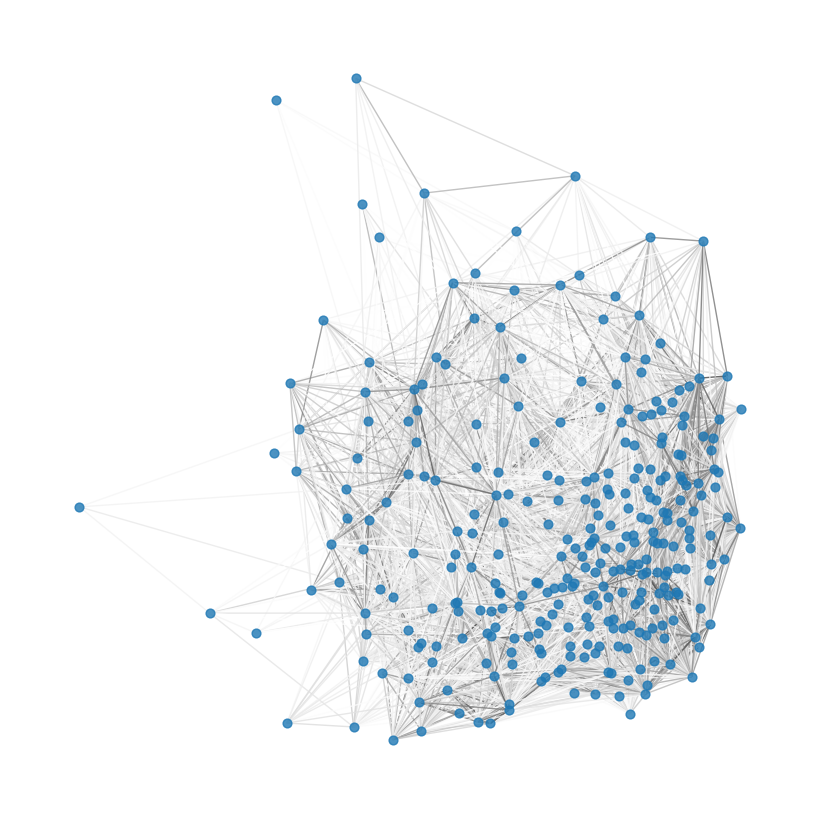

In [15]:
np.random.seed(25)
selected_samples = np.random.choice(data.index, size = 300, replace = False)
selected_samples = max(nx.connected_components(correlation_network.subgraph(selected_samples)), key = len)
selected_graph = correlation_network.subgraph(selected_samples)
_ = selected_graph.edges(data = True)

plt.figure(figsize = (8, 8))
edges, weights = zip(*nx.get_edge_attributes(selected_graph, 'weight').items())
nx.draw_spring(selected_graph, node_size = 40, edgelist = edges, edge_color = weights, edge_cmap = plt.cm.Greys, alpha = 0.8)
plt.show()

## Use Louvain algorithm to identify partitions that maximize modularity
Partition is a dictionary that map node name to cluster ID

In [16]:
partition = community.best_partition(correlation_network, random_state = 25)

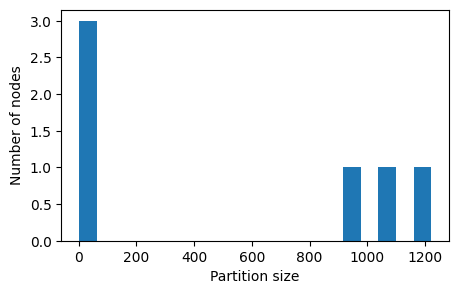

In [17]:
predicted = np.array([partition['Patient' + str(x)] for x in range(1, data.shape[0] + 1)])
unique, counts = np.unique(predicted, return_counts = True)

plt.figure(figsize = (5, 3))
plt.hist(counts, bins = 20)
plt.xlabel('Partition size'); plt.ylabel('Number of nodes')
plt.show()

### Observation
* There are a few outliers + 3 large clusters

### Visualize only large partitions

In [18]:
def view_large_clusters(labels, size_cutoff):
    outliers = []
    
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)

    for k in np.unique(labels):
        filt = labels == k
        
        if filt.sum() >= size_cutoff:
            plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], s = 2, label = 'Cluster ' + str(k))
        else:
            outliers.append(k)

    filt = [label for label in labels if label in outliers]
    plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], s = 2, label = 'Outliers', c = 'tab:gray', alpha = 0.3)       
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.legend()

    plt.subplot(1, 2, 2)

    for k in np.unique(labels):
        filt = labels == k
        
        if filt.sum() >= size_cutoff:
            plt.scatter(std_pca_embed[filt, 0], std_pca_embed[filt, 1], s = 2, label = 'Cluster ' + str(k))

    filt = [label for label in labels if label in outliers]
    plt.scatter(std_pca_embed[filt, 0], std_pca_embed[filt, 1], s = 2, label = 'Outliers', c = 'tab:gray', alpha = 0.3)
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()

    plt.tight_layout()
    plt.show()

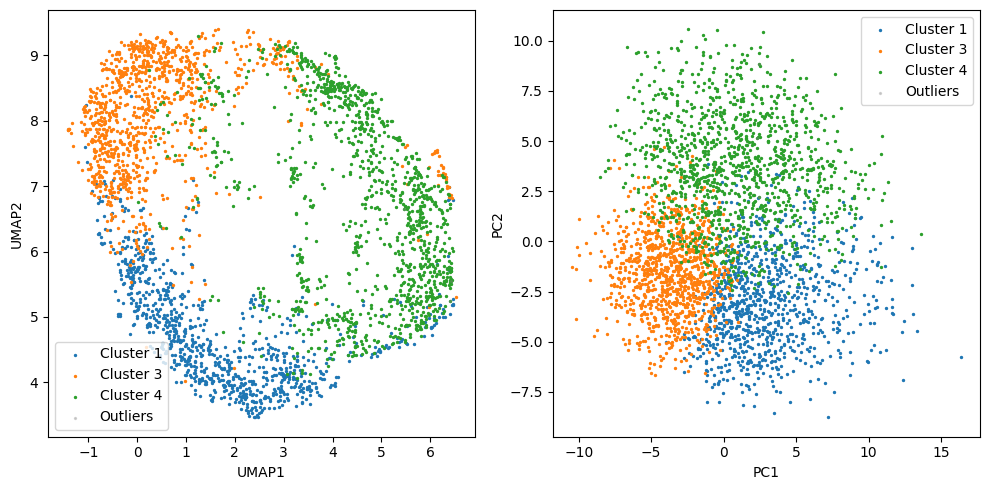

In [19]:
view_large_clusters(predicted, 20)

## Show these clusters on clustermap

c:\python38\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


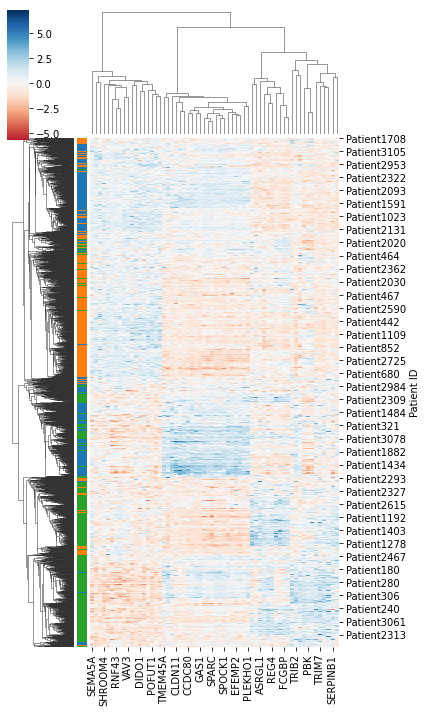

In [31]:
cluster_cmap = {1: 'tab:blue', 3: 'tab:orange', 4: 'tab:green'}
louvain_cluster_color = []

for x in predicted:
    if x in cluster_cmap:
        louvain_cluster_color.append(cluster_cmap[x])
    else: ## outliers
        louvain_cluster_color.append('tab:gray')
        
_ = sns.clustermap(data = std_data, metric = 'correlation', method = 'average', 
                   z_score = None, figsize = (6, 10), cmap = 'RdBu', center = 0, 
                   row_cluster = True, col_cluster = True, 
                   row_colors = louvain_cluster_color, col_colors = None)

### Observation
* Good agreement between Louvain network clustering and clustermap's dendrogram
* Some cluster contain sub-clusters

## Use mutation data to validate cluster

In [42]:
mutation_cmap = {'wt': 'tab:cyan', 'mt': 'tab:red', 'MSS': 'tab:cyan', 'MSI': 'tab:red'}

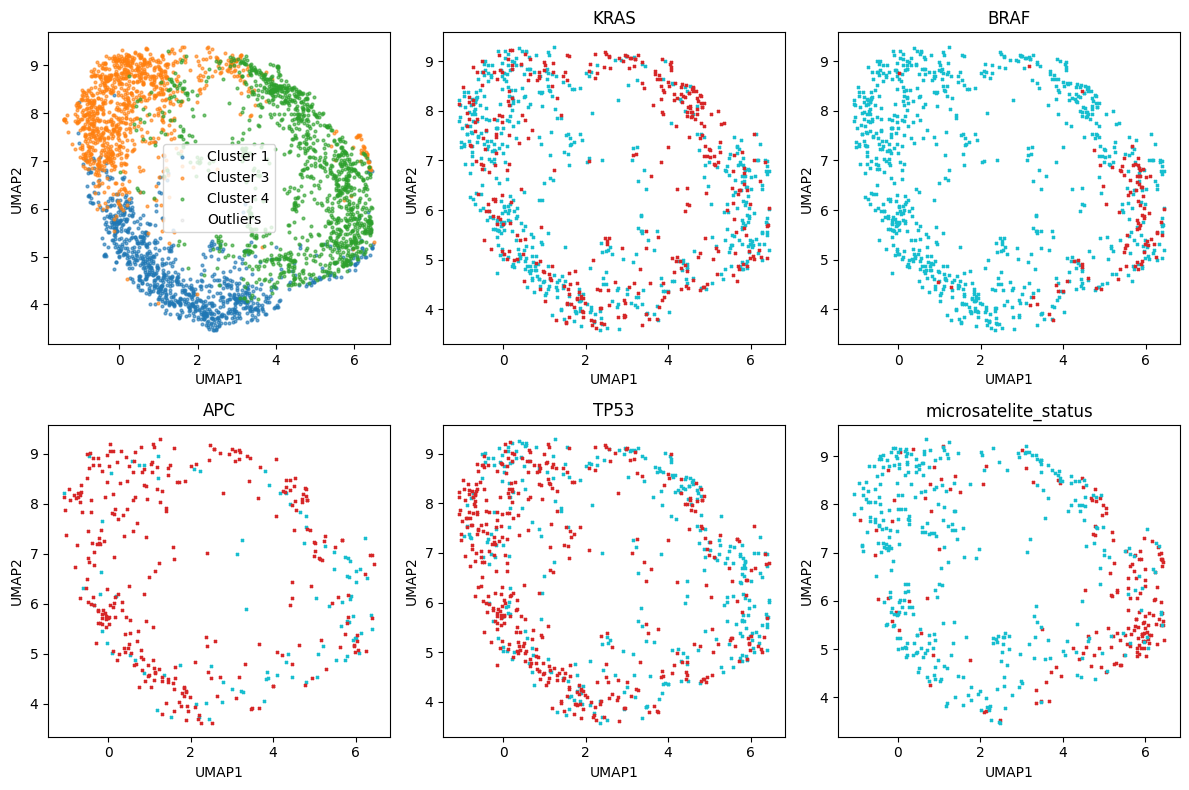

In [50]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 3, 1)
outliers = []
    
for k in np.unique(predicted):
    filt = predicted == k

    if filt.sum() >= 20:
        plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], s = 4, 
                    label = 'Cluster ' + str(k), alpha = 0.6)
    else:
        outliers.append(k)

filt = [p for p in predicted if p in outliers]
plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], s = 4, label = 'Outliers', 
            c = 'tab:gray', alpha = 0.1)       

plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.legend()

for i, mutation in enumerate(data.columns[first_mutation_column:], start = 2):
    plt.subplot(2, 3, i)

    for m in pd.unique(data[mutation]):
        if not pd.isna(m):
            filt = data[mutation] == m
            plt.scatter(final_umap_embed[filt, 0], final_umap_embed[filt, 1], s = 4, label = m,
                        marker = 'x', c = mutation_cmap[m])       

    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    plt.title(mutation)

plt.tight_layout()
plt.show()

### Add cluster label to data and summarize frequency

In [49]:
mutation_rate = pd.DataFrame(0, index = [1, 3, 4],  
                             columns = data.columns[first_mutation_column:])

for m in mutation_rate.columns:
    for c in mutation_rate.index:
        wt_count = (((data[m] == 'wt') | (data[m] == 'MSS')) & (predicted == c)).sum()
        mt_count = (((data[m] == 'mt') | (data[m] == 'MSI')) & (predicted == c)).sum()
        mutation_rate.loc[c, m] = mt_count / (wt_count + mt_count)
        
mutation_rate.head()

,KRAS,BRAF,APC,TP53,microsatelite_status
1,0.336770,0.039146,0.805755,0.683983,0.157895
3,0.335766,0.011364,0.892857,0.660870,0.159341
4,0.479452,0.218750,0.619718,0.382979,0.535398


### Observation
* Cluster 4 is associated with high BRAF, high MSI, low APC, and low TP53